In [2]:
import os
import zipfile
import tensorflow as tf
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model

In [3]:

base_dir = 'data'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

# Directory with our training cat pictures
train_cat_dir = os.path.join(train_dir, 'cat')

# Directory with our training butterfly pitures
train_butterfly_dir = os.path.join(train_dir, 'butterfly')

# Directory with our training elephant pictures
train_elephant_dir = os.path.join(train_dir, 'elephant')

# Directory with our training chicken pictures
train_chicken_dir = os.path.join(train_dir, 'chicken')

# Directory with our training cow pictures
train_cow_dir = os.path.join(train_dir, 'cow')

# Directory with our training dog pictures
train_dog_dir = os.path.join(train_dir, 'dog')

# Directory with our training horse pictures
train_horse_dir = os.path.join(train_dir, 'horse')

# Directory with our training sheep pictures
train_sheep_dir = os.path.join(train_dir, 'sheep')

# Directory with our training squirrel pictures
train_squirrel_dir = os.path.join(train_dir, 'squirrel')

# Directory with our training spider pictures
train_spider_dir = os.path.join(train_dir, 'spider')

# Directory with our validation cat pictures
validation_cat_dir = os.path.join(validation_dir, 'cat')

# Directory with our validation dog pictures
validation_dog_dir = os.path.join(validation_dir, 'dog')

# Directory with our validation butterfly pitures
validation_butterfly_dir = os.path.join(validation_dir, 'butterfly')

# Directory with our validation elephant pictures
validation_elephant_dir = os.path.join(validation_dir, 'elephant')

# Directory with our validation chicken pictures
validation_chicken_dir = os.path.join(validation_dir, 'chicken')

# Directory with our validation cow pictures
validation_cow_dir = os.path.join(validation_dir, 'cow')

# Directory with our validation horse pictures
validation_horse_dir = os.path.join(validation_dir, 'horse')

# Directory with our validation sheep pictures
validation_sheep_dir = os.path.join(validation_dir, 'sheep')

# Directory with our validation squirrel pictures
validation_squirrel_dir = os.path.join(validation_dir, 'squirrel')

# Directory with our validation spider pictures
validation_spider_dir = os.path.join(validation_dir, 'spider')

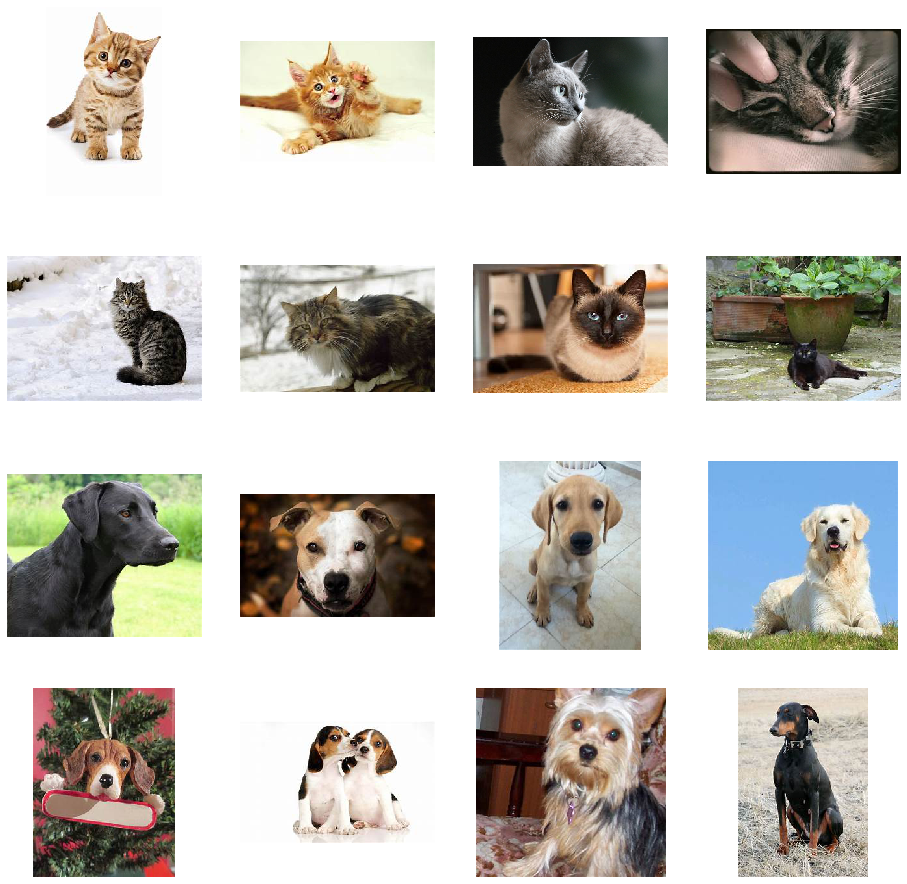

In [4]:
# Set up matplotlib fig, and size it to fit 4x4 pics
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index = 100
train_cat_fnames = os.listdir( train_cat_dir )
train_dog_fnames = os.listdir( train_dog_dir )


next_cat_pix = [os.path.join(train_cat_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dog_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]
# 17539
# 8640

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [5]:
# Import the inception model  
from keras.applications.inception_v3 import InceptionV3

In [6]:
pre_trained_model = InceptionV3(input_shape = (299, 299, 3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')

In [7]:
for layer in pre_trained_model.layers:
    layer.trainable = False

In [8]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if(logs.get('accuracy') > 0.959):
            print("\nReached 95.9% accuracy so cancelling training!")
            self.model.stop_training = True

In [9]:
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.layers import Dense

out = pre_trained_model.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation = 'relu')(out)
out = Dense(512, activation = 'relu')(out)
total_classes = 10
predictions = Dense(total_classes, activation = 'softmax')(out)

model = Model(inputs = pre_trained_model.input, outputs = predictions)
model.compile(Adam(lr = .0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [10]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'categorical', 
                                                    target_size = (299, 299))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'categorical', 
                                                          target_size = (299, 299))

Found 25650 images belonging to 10 classes.
Found 2871 images belonging to 10 classes.


In [12]:
callbacks = myCallback()
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 100,
            validation_steps = 50,
            verbose = 1,
            callbacks = [callbacks])

Epoch 1/100
100/100 [==============================] - 120s 1s/step - loss: 1.3343 - accuracy: 0.6340 - val_loss: 0.6138 - val_accuracy: 0.8910
Epoch 2/100
100/100 [==============================] - 97s 967ms/step - loss: 0.5717 - accuracy: 0.8435 - val_loss: 0.0538 - val_accuracy: 0.9750
Epoch 3/100
100/100 [==============================] - 99s 986ms/step - loss: 0.4191 - accuracy: 0.8805 - val_loss: 0.1649 - val_accuracy: 0.9526
Epoch 4/100
100/100 [==============================] - 99s 989ms/step - loss: 0.3890 - accuracy: 0.8885 - val_loss: 0.2285 - val_accuracy: 0.9680
Epoch 5/100
100/100 [==============================] - 99s 993ms/step - loss: 0.3353 - accuracy: 0.9080 - val_loss: 0.3287 - val_accuracy: 0.9660
Epoch 6/100
100/100 [==============================] - 101s 1s/step - loss: 0.3835 - accuracy: 0.8844 - val_loss: 0.1268 - val_accuracy: 0.9677
Epoch 7/100
100/100 [==============================] - 104s 1s/step - loss: 0.3391 - accuracy: 0.8925 - val_loss: 0.0218 - val_a

Epoch 57/100
100/100 [==============================] - 63s 635ms/step - loss: 0.2432 - accuracy: 0.9215 - val_loss: 0.1120 - val_accuracy: 0.9770
Epoch 58/100
100/100 [==============================] - 62s 620ms/step - loss: 0.2151 - accuracy: 0.9325 - val_loss: 0.0145 - val_accuracy: 0.9707
Epoch 59/100
100/100 [==============================] - 62s 621ms/step - loss: 0.2412 - accuracy: 0.9250 - val_loss: 0.0012 - val_accuracy: 0.9820
Epoch 60/100
100/100 [==============================] - 63s 632ms/step - loss: 0.2384 - accuracy: 0.9255 - val_loss: 0.3317 - val_accuracy: 0.9710
Epoch 61/100
100/100 [==============================] - 64s 641ms/step - loss: 0.2443 - accuracy: 0.9230 - val_loss: 0.0049 - val_accuracy: 0.9768
Epoch 62/100
100/100 [==============================] - 63s 634ms/step - loss: 0.2434 - accuracy: 0.9255 - val_loss: 0.0035 - val_accuracy: 0.9810
Epoch 63/100
100/100 [==============================] - 66s 656ms/step - loss: 0.2259 - accuracy: 0.9265 - val_loss: 0

In [13]:
model.save("model.h5")

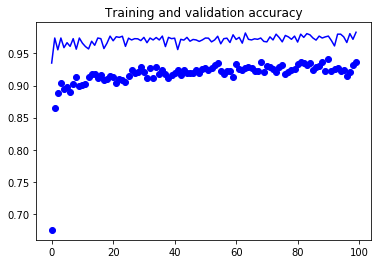

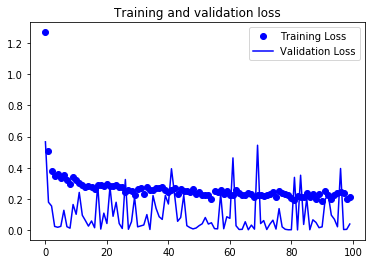

In [38]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [42]:
import numpy as np
from keras.preprocessing import image

def predict(model, image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    x /= 255.
    
    y_prob = model.predict(x)
    y_classes = y_prob.argmax(axis = -1)

    for i in label_map:
        if label_map[i] == y_classes[0]:
            return i
    
    return "-1"

In [43]:
predict(model, '/home/eeshan/Pictures/cat_1.jpeg')

'cat'